# 🔥 热力图 (Heatmap) - 相关性矩阵分析

## 什么是热力图？

热力图使用颜色深浅表示数值大小，最常用于展示**变量间的相关性矩阵**。

## 适用场景

| 场景 | 示例 |
|------|------|
| 相关性分析 | 哪些特征与目标变量相关？ |
| 多重共线性检测 | 特征之间是否高度相关？ |
| 特征选择依据 | 选择与目标相关但互不相关的特征 |
| 模式发现 | 发现变量间的聚类关系 |

## 关键指标解读

| 相关系数 | 强度 | 含义 |
|----------|------|------|
| 0.8 ~ 1.0 | 强正相关 | 一个变量增加，另一个也增加 |
| 0.5 ~ 0.8 | 中等正相关 | 有一定正向关系 |
| 0.0 ~ 0.5 | 弱正相关 | 关系较弱 |
| -0.5 ~ 0.0 | 弱负相关 | 关系较弱 |
| -0.8 ~ -0.5 | 中等负相关 | 有一定负向关系 |
| -1.0 ~ -0.8 | 强负相关 | 一个变量增加，另一个减少 |

## ⚠️ 注意事项

- 相关性 ≠ 因果关系
- 高相关的特征可能导致多重共线性
- 考虑使用Spearman相关系数处理非线性关系


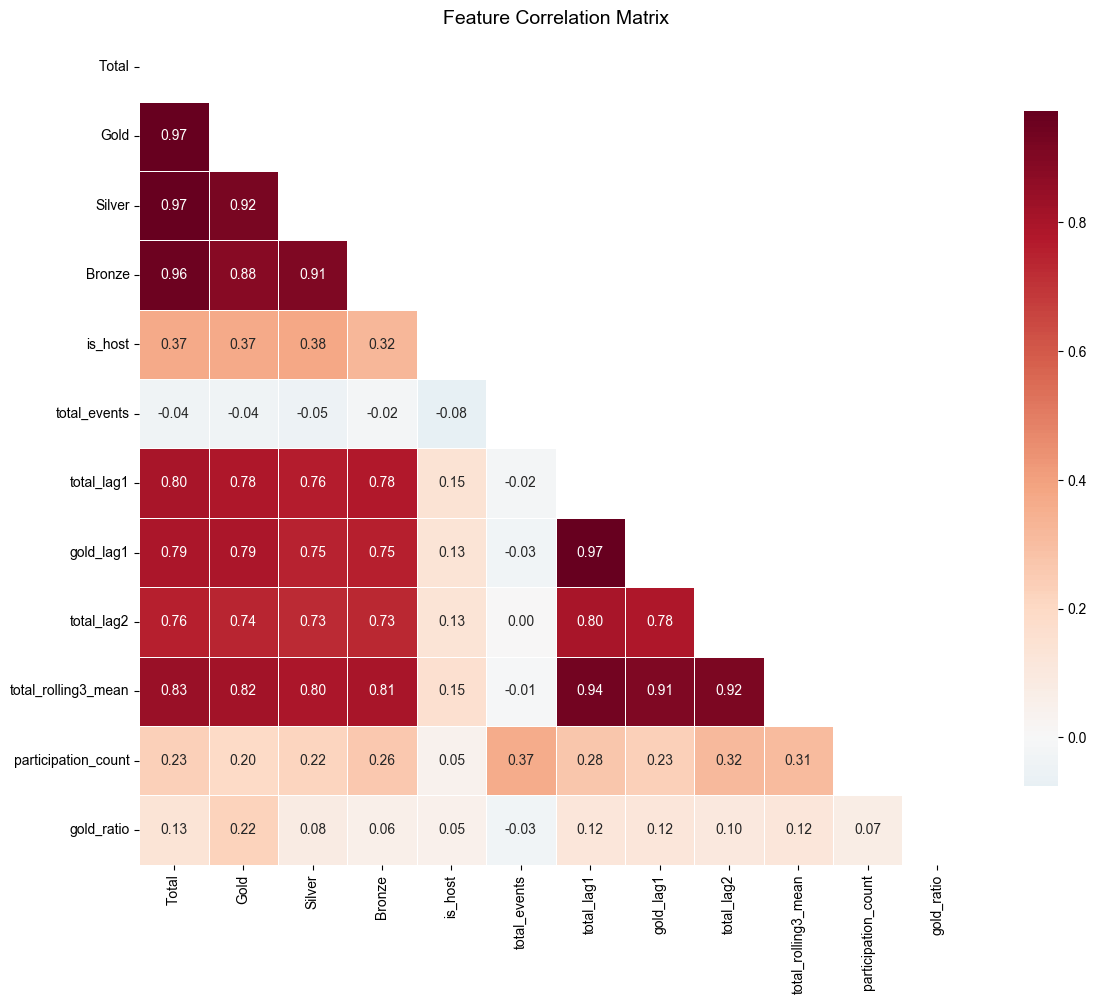

📊 各特征与Total的相关性（降序）:
  Silver: 0.974 (强相关)
  Gold: 0.970 (强相关)
  Bronze: 0.957 (强相关)
  total_rolling3_mean: 0.835 (强相关)
  total_lag1: 0.800 (强相关)
  gold_lag1: 0.791 (强相关)
  total_lag2: 0.759 (强相关)
  is_host: 0.368 (弱相关)
  participation_count: 0.232 (弱相关)
  gold_ratio: 0.134 (弱相关)
  total_events: -0.037 (弱相关)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv('../preprocessing/2025C示例/processed_medal_data.csv')

# 选择数值型特征
numeric_features = ['Total', 'Gold', 'Silver', 'Bronze', 'is_host', 'total_events',
                    'total_lag1', 'gold_lag1', 'total_lag2', 'total_rolling3_mean',
                    'participation_count', 'gold_ratio']

# 计算相关性矩阵
corr_matrix = df[numeric_features].corr()

# 绘制热力图
plt.figure(figsize=(12, 10))

# 只显示下三角（避免重复信息）
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,           # 显示数值
            fmt='.2f',            # 保留2位小数
            cmap='RdBu_r',        # 红蓝色系，中间为白色
            center=0,             # 以0为中心
            square=True,          # 正方形格子
            linewidths=0.5,       # 格子边框
            cbar_kws={'shrink': 0.8})

plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# 与目标变量的相关性排序
print("📊 各特征与Total的相关性（降序）:")
correlation_with_target = corr_matrix['Total'].sort_values(ascending=False)
for feature, corr in correlation_with_target.items():
    if feature != 'Total':
        strength = '强' if abs(corr) > 0.7 else '中' if abs(corr) > 0.4 else '弱'
        print(f"  {feature}: {corr:.3f} ({strength}相关)")


## 🎯 2025美赛C题解读：特征选择依据

### 热力图关键发现

**1. 与目标变量(Total)相关性排序**

| 特征 | 相关系数 | 强度 | 业务含义 |
|------|----------|------|----------|
| Gold | 0.97 | 强 | 金牌数与总数高度正相关（但不能作为预测特征！） |
| total_rolling3_mean | 0.83 | 强 | 历史平均是最佳预测特征 |
| total_lag1 | 0.80 | 强 | 上届成绩强预测因子 |
| gold_lag1 | 0.79 | 强 | 上届金牌数也有预测能力 |
| total_lag2 | 0.76 | 中-强 | 前两届成绩仍有参考价值 |
| is_host | 0.37 | 中 | 东道主效应存在但相关性中等 |
| participation_count | 0.23 | 弱 | 参赛经验有一定作用 |

**2. 特征间共线性分析**

⚠️ 发现以下**高度共线**的特征组：
- `Gold`, `Silver`, `Bronze` 与 `Total` 高度相关（>0.9）
- `total_lag1`, `gold_lag1`, `total_rolling3_mean` 互相关（>0.8）

**建议处理**：
- 只保留`total_lag1`和`total_rolling3_mean`之一
- 或使用**Ridge/Lasso正则化**自动处理共线性

**3. is_host的特殊性**

- 与目标相关性0.37，看似"中等"
- 但它是**类别变量**，不能只看线性相关
- 从箱线图已验证：东道主效应**非常显著**
- 属于**"低相关但高影响"**的特征

### 推荐的特征选择方案

```
最终建模特征:
├── 历史表现
│   ├── total_lag1 (上届成绩)
│   └── total_rolling3_mean (近3届平均)
├── 东道主效应
│   └── is_host (0/1)
├── 经验积累
│   └── participation_count (参赛届数)
└── 控制变量
    └── total_events (当届项目数，用于归一化)
```

### 答题建议
> "通过相关性热力图分析，我们选择total_lag1(r=0.80)、total_rolling3_mean(r=0.83)作为核心历史特征，同时纳入is_host捕捉东道主效应。为避免多重共线性，我们对高度相关的滞后特征进行了筛选，最终保留5个预测变量。"
